# Lab J1 — Après-midi : Régression Linéaire
**Formation IA, Deep Learning & Machine Learning** — Julien Rolland
**Public :** M2 Développement Fullstack

---

## Objectifs

- Charger et explorer un dataset réel avec Pandas
- Implémenter la solution analytique des moindres carrés en NumPy
- Implémenter la descente de gradient from scratch
- Comparer les trois approches (analytique, GD, sklearn)


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print('NumPy  :', np.__version__)
print('Pandas :', pd.__version__)


NumPy  : 2.4.2
Pandas : 2.3.3


---
## Partie 1 — Dataset

### 1.1 Chargement


In [2]:
data = load_diabetes()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

print('Shape :', df.shape)
df.head()


Shape : (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

### 1.2 Exploration


In [4]:
df.describe().round(2)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
mean,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,152.13
std,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,77.09
min,-0.11,-0.04,-0.09,-0.11,-0.13,-0.12,-0.10,-0.08,-0.13,-0.14,25.00
25%,-0.04,-0.04,-0.03,-0.04,-0.03,-0.03,-0.04,-0.04,-0.03,-0.03,87.00
50%,0.01,-0.04,-0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,140.50
75%,0.04,0.05,0.03,0.04,0.03,0.03,0.03,0.03,0.03,0.03,211.50
max,0.11,0.05,0.17,0.13,0.15,0.20,0.18,0.19,0.13,0.14,346.00


In [5]:
print('NaN :', df.isna().sum().sum())


NaN : 0


### 1.3 Visualisation — BMI vs target


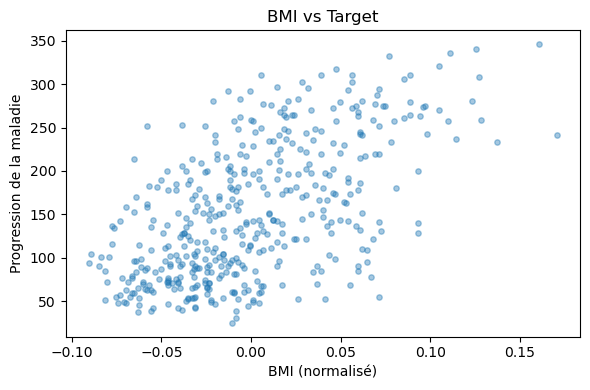

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df['bmi'], df['target'], alpha=0.4, s=15)
ax.set_xlabel('BMI (normalisé)')
ax.set_ylabel('Progression de la maladie')
ax.set_title('BMI vs Target')
plt.tight_layout()
plt.show()


### 1.4 Corrélations features / cible


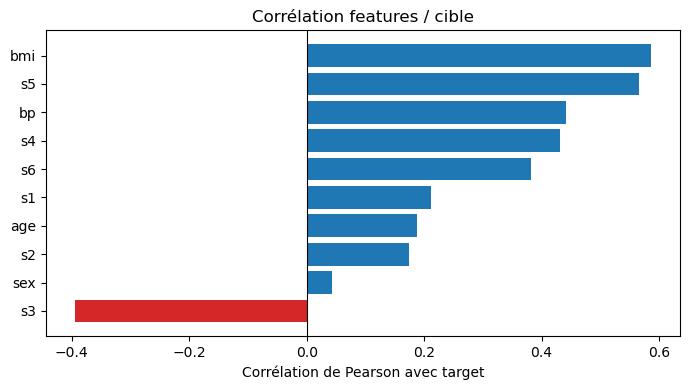

In [7]:
corr = df.drop(columns='target').corrwith(df['target']).sort_values()

fig, ax = plt.subplots(figsize=(7, 4))
colors = ['#d62728' if v < 0 else '#1f77b4' for v in corr]
ax.barh(corr.index, corr.values, color=colors)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Corrélation de Pearson avec target')
ax.set_title('Corrélation features / cible')
plt.tight_layout()
plt.show()


---
## Partie 2 — Préparation des données

### 2.1 Train / test split


In [8]:
X_raw = data.data          # (442, 10)
y_raw = data.target        # (442,)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

print('Train :', X_train_raw.shape, y_train.shape)
print('Test  :', X_test_raw.shape,  y_test.shape)


Train : (353, 10) (353,)
Test  : (89, 10) (89,)


### 2.2 Ajout du biais

Pour absorber le terme constant $b$ dans le vecteur de poids $\mathbf{w}$, on augmente $X$ d'une colonne de 1 :

$$\tilde{X} = [\mathbf{1} \mid X], \quad \tilde{\mathbf{w}} = [b, w_1, \dots, w_d]^\top$$

$$\hat{y} = \tilde{X}\, \tilde{\mathbf{w}}$$


In [9]:
def add_bias(X: np.ndarray) -> np.ndarray:
    """Prepend a column of ones to X.  Shape: (m, d) -> (m, d+1)."""
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train = add_bias(X_train_raw)
X_test  = add_bias(X_test_raw)

print('X_train shape :', X_train.shape)
print('X_test  shape :', X_test.shape)


X_train shape : (353, 11)
X_test  shape : (89, 11)


### 2.3 Normalisation

La descente de gradient est sensible à l'échelle des features.
On normalise $X$ et $y$ avec les statistiques du **train set** uniquement (no data leakage).

In [10]:
# Normalisation de X (sans la colonne de biais)
X_mean = X_train_raw.mean(axis=0)
X_std  = X_train_raw.std(axis=0)

X_train_norm = add_bias((X_train_raw - X_mean) / X_std)
X_test_norm  = add_bias((X_test_raw  - X_mean) / X_std)

# Normalisation de y
y_mean = y_train.mean()
y_std  = y_train.std()

y_train_norm = (y_train - y_mean) / y_std
# y_test reste dans l'espace original pour évaluation finale


---
## Partie 3 — Solution Analytique

La solution des moindres carrés minimise $\|y - Xw\|^2$ :

$$\mathbf{w}^* = (X^\top X)^{-1} X^\top y$$

En pratique on résout le système linéaire $(X^\top X)\,\mathbf{w} = X^\top y$ avec `np.linalg.solve` (plus stable que l'inversion explicite).

### 3.1 Implémentation


In [11]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean Squared Error."""
    diff = y_true - y_pred
    return float(diff @ diff / len(y_true))

def analytical_solution(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Ordinary Least Squares via np.linalg.solve."""
    return np.linalg.solve(X.T @ X, X.T @ y)


### 3.2 Entraînement et évaluation


In [12]:
w_ols = analytical_solution(X_train, y_train)

y_pred_train_ols = X_train @ w_ols
y_pred_test_ols  = X_test  @ w_ols

mse_train_ols = mse(y_train, y_pred_train_ols)
mse_test_ols  = mse(y_test,  y_pred_test_ols)

print(f'OLS — MSE train : {mse_train_ols:.2f}')
print(f'OLS — MSE test  : {mse_test_ols:.2f}')


OLS — MSE train : 2868.55
OLS — MSE test  : 2900.19


### 3.3 Prédictions vs réalité


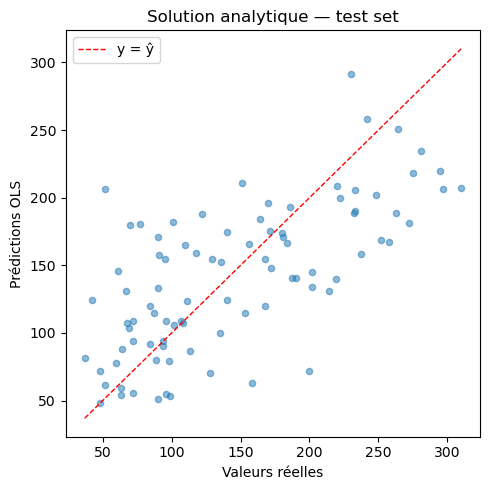

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
lims = [y_test.min(), y_test.max()]
ax.scatter(y_test, y_pred_test_ols, alpha=0.5, s=20)
ax.plot(lims, lims, 'r--', linewidth=1, label='y = ŷ')
ax.set_xlabel('Valeurs réelles')
ax.set_ylabel('Prédictions OLS')
ax.set_title('Solution analytique — test set')
ax.legend()
plt.tight_layout()
plt.show()


---
## Partie 4 — Descente de Gradient

### 4.1 Implémentation

La mise à jour du gradient pour MSE est :

$$\mathbf{w} \leftarrow \mathbf{w} - \alpha \cdot \frac{2}{m} X^\top (X\mathbf{w} - y)$$

In [14]:
def gradient_descent(
    X: np.ndarray,
    y: np.ndarray,
    lr: float = 0.1,
    n_iters: int = 1000,
) -> tuple:
    """
    Gradient descent for linear regression.

    Returns
    -------
    w       : final weight vector, shape (d,)
    history : MSE at each iteration, shape (n_iters,)
    """
    m, d = X.shape
    w = np.zeros(d)
    history = np.empty(n_iters)

    for i in range(n_iters):
        residuals = X @ w - y                   # (m,)
        grad = (2 / m) * (X.T @ residuals)      # (d,)
        w -= lr * grad
        history[i] = residuals @ residuals / m  # MSE

    return w, history


### 4.2 Entraînement

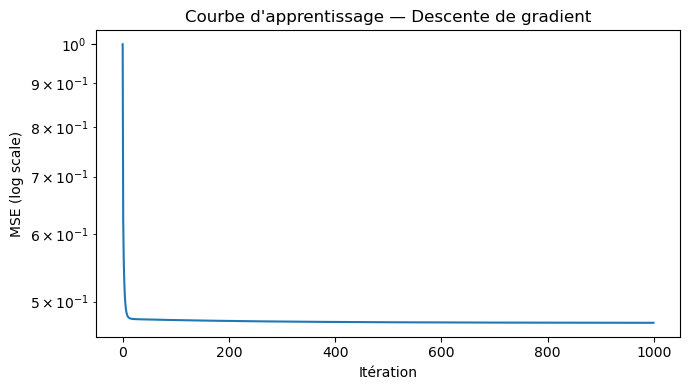

In [15]:
w_gd, history = gradient_descent(X_train_norm, y_train_norm, lr=0.1, n_iters=1000)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(history)
ax.set_yscale('log')
ax.set_xlabel('Itération')
ax.set_ylabel('MSE (log scale)')
ax.set_title('Courbe d\'apprentissage — Descente de gradient')
plt.tight_layout()
plt.show()


### 4.3 Évaluation (dénormalisation)

In [16]:
y_pred_train_norm = X_train_norm @ w_gd
y_pred_test_norm  = X_test_norm  @ w_gd

# Dénormaliser les prédictions vers l'espace original de y
y_pred_train_gd = y_pred_train_norm * y_std + y_mean
y_pred_test_gd  = y_pred_test_norm  * y_std + y_mean

mse_train_gd = mse(y_train, y_pred_train_gd)
mse_test_gd  = mse(y_test,  y_pred_test_gd)

print(f'GD — MSE train : {mse_train_gd:.2f}')
print(f'GD — MSE test  : {mse_test_gd:.2f}')


GD — MSE train : 2869.33
GD — MSE test  : 2895.30


---
## Partie 5 — Comparaison avec scikit-learn

### 5.1 LinearRegression


In [17]:
model = LinearRegression()
model.fit(X_train_raw, y_train)

y_pred_train_sk = model.predict(X_train_raw)
y_pred_test_sk  = model.predict(X_test_raw)

mse_train_sk = mse(y_train, y_pred_train_sk)
mse_test_sk  = mse(y_test,  y_pred_test_sk)

print(f'sklearn — MSE train : {mse_train_sk:.2f}')
print(f'sklearn — MSE test  : {mse_test_sk:.2f}')


sklearn — MSE train : 2868.55
sklearn — MSE test  : 2900.19


### 5.2 Tableau comparatif


In [18]:
results = pd.DataFrame({
    'Méthode'   : ['Analytique (OLS)', 'Gradient Descent', 'sklearn'],
    'MSE train' : [mse_train_ols, mse_train_gd, mse_train_sk],
    'MSE test'  : [mse_test_ols,  mse_test_gd,  mse_test_sk],
}).set_index('Méthode').round(2)

results


,MSE train,MSE test
Méthode,,
Analytique (OLS),2868.55,2900.19
Gradient Descent,2869.33,2895.30
sklearn,2868.55,2900.19


### 5.3 Comparaison des coefficients appris


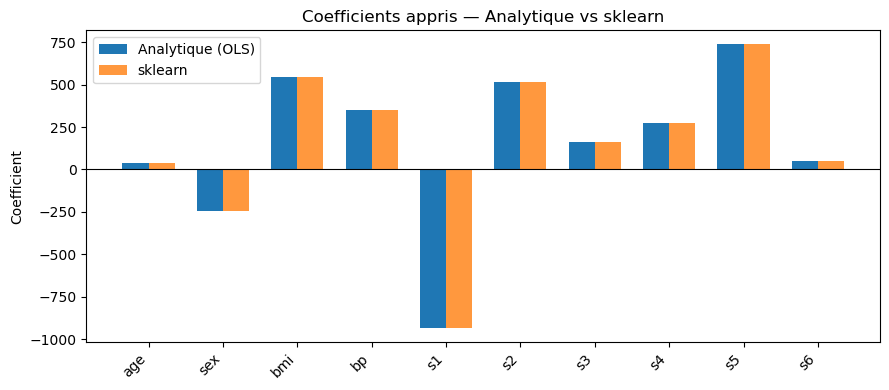

In [19]:
# Coefficients OLS (sans le biais, i.e. indice 1..)
coef_ols = w_ols[1:]
coef_sk  = model.coef_

feature_names = data.feature_names
x_pos = np.arange(len(feature_names))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(x_pos - width / 2, coef_ols, width, label='Analytique (OLS)')
ax.bar(x_pos + width / 2, coef_sk,  width, label='sklearn', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Coefficient')
ax.set_title('Coefficients appris — Analytique vs sklearn')
ax.legend()
plt.tight_layout()
plt.show()


---
## Conclusion

| Méthode | MSE train | MSE test | Remarque |
|---|---|---|---|
| Analytique (OLS) | 2868.55 | 2900.19 | Solution exacte, $O(d^3)$ |
| Descente de gradient | 2869.33 | 2895.30 | Itératif, scalable |
| sklearn | 2868.55 | 2900.19 | Référence |

> Les trois méthodes convergent vers la même solution : la **descente de gradient est la clé de tout le deep learning**. En passant d'une fonction de perte convexe (MSE) à des réseaux profonds non-convexes, le même algorithme reste au cœur de l'optimisation — complété par la rétropropagation pour calculer les gradients.
